In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'CSE-156/Analysis Study'

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/My Drive/CSE-156/Analysis Study


In [2]:
# install necessary libraries
!pip install transformers datasets pipeline
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 4.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_6

In [3]:
# import libraries
from datasets import load_dataset
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import ast
import math
import nltk
import spacy
from tqdm import tqdm

In [33]:
# read squad v1 results file (includes original data)
file_dir = '/content/drive/My Drive/{}/squad_pred.csv'.format(FOLDERNAME)
squad_df = pd.read_csv(file_dir)
squad_df

,id,title,context,question,answers,prediction
0,57105da9a58dae1900cd69a1,Huguenot,Huguenot numbers peaked near an estimated two ...,What treaty ended the Wars of Religion?,"{'text': array(['the Edict of Nantes', 'Edict ...",Edict of Nantes
1,57094b4f9928a814004714f6,Sky_(United_Kingdom),While BSkyB had been excluded from being a par...,What consortium was BSkyB excluded from?,"{'text': array(['ONdigital', 'ONdigital', 'ONd...",ONdigital
2,572905ce1d04691400778f84,Immune_system,Phagocytosis is an important feature of cellul...,Phagocytes can be called to a specific locatio...,"{'text': array(['cytokines', 'cytokines', 'cyt...",cytokines
3,57282358ff5b5019007d9dde,"Jacksonville,_Florida",Mean monthly temperatures range from around 53...,What is Jacksonville's hottest recorded temper...,"{'text': array(['104 °F', '104 °F', '104 °F'],...",104 °
4,571caac55efbb31900334dc9,Oxygen,By the late 19th century scientists realized t...,What minor amount of liquid oxygen was produce...,"{'text': array(['few drops', 'a few drops', 'a...",a few drops
...,...,...,...,...,...,...
10565,571161092419e314009555d7,Steam_engine,It is possible to use a mechanism based on a p...,What is an example of a rotary engine without ...,"{'text': array(['Wankel', 'Wankel', 'the Wanke...",Wankel engine
10566,5728e5224b864d1900165036,Civil_disobedience,Civil disobedients have chosen a variety of di...,Who lived in a tree to prevent it from being c...,"{'text': array(['Julia Butterfly Hill', 'Julia...",Julia Butterfly Hill
10567,5725bae289a1e219009abd90,Ctenophora,"Almost all ctenophores are predators, taking p...",How much can Ctenophores eat in one day?,"{'text': array(['ten times their own weight', ...",ten times their own weight
10568,57299d1c1d04691400779582,Prime_number,The fundamental theorem of arithmetic continue...,What is one example of a unique factorization ...,"{'text': array(['the Gaussian integers Z[i]', ...","Gaussian integers Z[i],"


In [5]:
# clean up answers columns -> convert back to list of strings, clean up whitespace in predictions
for index, row in squad_df.iterrows():
  text = row['answers']

  # remove all extra characters
  text = text.replace("\n", "")
  text = text.replace('"', '')
  text = text.replace("'", '')

  # get list of answers as a string
  start = text.index('[')
  end = text.index(']')
  list_string = text[start:end+1]

  # convert to actual list
  actual_list = list_string.strip("[]").split(', ')
  actual_list = [answer.strip() for answer in actual_list] # remove leading/trailing whitespace
  row['answers'] = actual_list

  # clean whitespace off of predictions
  if isinstance(row['prediction'], str):
    row['prediction'] = row['prediction'].strip()

In [7]:
# basic statistics
print(f"Number of entries: {squad_df.shape[0]}")
print(f"Columns: {squad_df.columns}")

titles = squad_df['title'].unique()
print(f"\nGroups ({len(titles)}): {titles}")

avg_context_length = (squad_df['context'].apply(len)).mean()
print(f"\nAverage length of context text (characters): {avg_context_length:.2f}")

Number of entries: 10570
Columns: Index(['id', 'title', 'context', 'question', 'answers', 'prediction'], dtype='object')

Groups (48): ['Huguenot' 'Sky_(United_Kingdom)' 'Immune_system' 'Jacksonville,_Florida'
 'Oxygen' 'Force' 'American_Broadcasting_Company' 'Scottish_Parliament'
 'Pharmacy' 'European_Union_law' 'Private_school' 'Teacher' 'Islamism'
 'Super_Bowl_50' 'Newcastle_upon_Tyne' 'Amazon_rainforest'
 'Computational_complexity_theory' 'Doctor_Who' 'Apollo_program'
 'Economic_inequality' 'Nikola_Tesla' 'Chloroplast'
 'Victoria_and_Albert_Museum' 'Fresno,_California' 'Yuan_dynasty'
 'French_and_Indian_War' '1973_oil_crisis' 'Civil_disobedience'
 'Steam_engine' 'United_Methodist_Church' 'Black_Death' 'Packet_switching'
 'Imperialism' 'Genghis_Khan' 'Prime_number' 'Martin_Luther'
 'Harvard_University' 'Victoria_(Australia)' 'Southern_California'
 'University_of_Chicago' 'Geology' 'Warsaw' 'Normans' 'Ctenophora'
 'Intergovernmental_Panel_on_Climate_Change' 'Kenya' 'Construction'
 'R

In [8]:
def is_empty(x):
  # if string -> not empty
  if isinstance(x, str):
    return False
  else:
    if math.isnan(x):
      return True
    else:
      return False

In [9]:
# model didn't predict anything -> confidence score was too low
empty_predictions = squad_df[squad_df['prediction'].apply(is_empty)]
empty_predictions = empty_predictions.reset_index(drop=True)
empty_predictions

,id,title,context,question,answers,prediction
0,57274ca8dd62a815002e9aa5,Private_school,"Legally, only non-profit trusts and societies ...",What country has the most illiterate adults in...,"[India, India, India]",NaN
1,572fcb6da23a5019007fc9f1,Scottish_Parliament,The specific devolved matters are all subjects...,Where are reserved matters stated in the Scotl...,"[Schedule 5, Schedule 5, Schedule 5]",NaN
2,56d720c70d65d21400198398,Super_Bowl_50,"As opposed to broadcasts of primetime series, ...",What followed the late local programming after...,"[The Late Late Show with James Corden., The La...",NaN
3,5728fb6a1d04691400778ef8,Civil_disobedience,"One theory is that, while disobedience may be ...",Why should someone not commit a crime when the...,"[not being a civil disobedient, viewed as not ...",NaN
4,5729e02f1d0469140077963c,Economic_inequality,Another cause is the rate at which income is t...,What index is an indicator of the effects of t...,"[the Gini index, Gini, Gini]",NaN
...,...,...,...,...,...,...
900,5726e5c95951b619008f81cc,Pharmacy,The clinical pharmacist's role involves creati...,What is involved in a review of prescribed med...,[an evaluation of the appropriateness of the d...,NaN
901,57264684708984140094c127,Black_Death,The Black Death is thought to have originated ...,For how long did the plague stick around?,"[until the 19th century, until the 19th centur...",NaN
902,5710ed7bb654c5140001fa2c,Huguenot,Some Huguenots fought in the Low Countries alo...,Who did the Dutch fight in the Dutch Revolt?,"[Spain, Spain, Spain]",NaN
903,572a14af3f37b319004786c4,Immune_system,The immune system is a system of many biologic...,What is the immune system of the brained known...,"[neuroimmune system, neuroimmune, neuroimmune ...",NaN


In [11]:
# incorrect predictions
def is_correct(row):
  if (not isinstance(row['prediction'], str) and math.isnan(row['prediction'])) or (row['prediction'] in row['answers']):
    return False
  return True

incorrect_predictions = squad_df[squad_df.apply(is_correct, axis=1)]
incorrect_predictions = incorrect_predictions.reset_index(drop=True)
incorrect_predictions

,id,title,context,question,answers,prediction
0,57282358ff5b5019007d9dde,"Jacksonville,_Florida",Mean monthly temperatures range from around 53...,What is Jacksonville's hottest recorded temper...,"[104 °F, 104 °F, 104 °F]",104 °
1,5737a9afc3c5551400e51f65,Force,The connection between macroscopic nonconserva...,What makes energy changes in a closed system?,"[nonconservative forces, nonconservative force...",entropy increases
2,5737534ec3c5551400e51eab,Force,Newton's Third Law is a result of applying sym...,When forces are from the presence of differnet...,"[Newtons Third, Newtons Third Law, Newtons Thi...",Newton's Third Law
3,572908c13f37b31900477fc0,Immune_system,Leukocytes (white blood cells) act like indepe...,What are three kinds of phagocytes?,"[macrophages, neutrophils, and dendritic cells...","macrophages, neutrophils, and dendritic cells"
4,5725bbec271a42140099d0d4,European_Union_law,European Union law is applied by the courts of...,What is the highest court in the European Union?,"[The European Court of Justice, The European C...",Court of Justice of the European Union
...,...,...,...,...,...,...
2014,572883153acd2414000dfa72,Yuan_dynasty,"Politically, the system of government created ...",How did the unequal treatment of Chinese versu...,"[colonial, somewhat strong colonial coloration...","colonial"" coloration"
2015,572fda6fb2c2fd140056850e,Scottish_Parliament,The total number of seats in the Parliament ar...,What set is a seat added to after being alloca...,"[constituency seats, constituency, second]",its constituency seats
2016,571161092419e314009555d7,Steam_engine,It is possible to use a mechanism based on a p...,What is an example of a rotary engine without ...,"[Wankel, Wankel, the Wankel engine]",Wankel engine
2017,57299d1c1d04691400779582,Prime_number,The fundamental theorem of arithmetic continue...,What is one example of a unique factorization ...,[the Gaussian integers Z[i],"Gaussian integers Z[i],"


In [12]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.02k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
import torch.nn as nn
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)

# test similarity for sentences
data = incorrect_predictions.iloc[0]
prediction = data['prediction']
answer_embeddings = model.encode(data['answers'])
prediction_embedding = model.encode(data['prediction'])

ans_emb = torch.from_numpy(answer_embeddings)
pred_emb = torch.from_numpy(prediction_embedding)
print(cos(pred_emb, ans_emb[2]))

tensor(0.8723)


In [14]:
# add max similarity between prediction and correct answers as new column
incorrect_predictions["max-similarity"] = "NO-SCORE"

# iterate rows -> scores
for index, row in tqdm(incorrect_predictions.iterrows(), total=incorrect_predictions.shape[0]):

  answer_embeddings = torch.from_numpy(model.encode(incorrect_predictions.iloc[index]['answers']))
  prediction_embedding = torch.from_numpy(model.encode(incorrect_predictions.iloc[index]['prediction']))

  scores = [(cos(prediction_embedding, ans_emb)).numpy() for ans_emb in answer_embeddings]

  incorrect_predictions.at[index, "max-similarity"] = max(scores)

incorrect_predictions

100%|██████████| 2019/2019 [05:25<00:00,  6.21it/s]


,id,title,context,question,answers,prediction,max-similarity
0,57282358ff5b5019007d9dde,"Jacksonville,_Florida",Mean monthly temperatures range from around 53...,What is Jacksonville's hottest recorded temper...,"[104 °F, 104 °F, 104 °F]",104 °,0.8722768
1,5737a9afc3c5551400e51f65,Force,The connection between macroscopic nonconserva...,What makes energy changes in a closed system?,"[nonconservative forces, nonconservative force...",entropy increases,0.4024096
2,5737534ec3c5551400e51eab,Force,Newton's Third Law is a result of applying sym...,When forces are from the presence of differnet...,"[Newtons Third, Newtons Third Law, Newtons Thi...",Newton's Third Law,0.97491324
3,572908c13f37b31900477fc0,Immune_system,Leukocytes (white blood cells) act like indepe...,What are three kinds of phagocytes?,"[macrophages, neutrophils, and dendritic cells...","macrophages, neutrophils, and dendritic cells",0.78414345
4,5725bbec271a42140099d0d4,European_Union_law,European Union law is applied by the courts of...,What is the highest court in the European Union?,"[The European Court of Justice, The European C...",Court of Justice of the European Union,0.9763757
...,...,...,...,...,...,...,...
2014,572883153acd2414000dfa72,Yuan_dynasty,"Politically, the system of government created ...",How did the unequal treatment of Chinese versu...,"[colonial, somewhat strong colonial coloration...","colonial"" coloration",0.8748111
2015,572fda6fb2c2fd140056850e,Scottish_Parliament,The total number of seats in the Parliament ar...,What set is a seat added to after being alloca...,"[constituency seats, constituency, second]",its constituency seats,0.964714
2016,571161092419e314009555d7,Steam_engine,It is possible to use a mechanism based on a p...,What is an example of a rotary engine without ...,"[Wankel, Wankel, the Wankel engine]",Wankel engine,0.97572494
2017,57299d1c1d04691400779582,Prime_number,The fundamental theorem of arithmetic continue...,What is one example of a unique factorization ...,[the Gaussian integers Z[i],"Gaussian integers Z[i],",0.97675353


In [15]:
# keep the rows only with max-similarity score below 0.7
true_incorrect = incorrect_predictions[incorrect_predictions['max-similarity'].apply(lambda x: x < 0.7)]
true_incorrect

,id,title,context,question,answers,prediction,max-similarity
1,5737a9afc3c5551400e51f65,Force,The connection between macroscopic nonconserva...,What makes energy changes in a closed system?,"[nonconservative forces, nonconservative force...",entropy increases,0.4024096
11,56e0fb887aa994140058e86c,Nikola_Tesla,"In 1898, Tesla demonstrated a radio-controlled...",What was the occasion for the boat demonstration?,"[an electrical exhibition, an electrical exhib...",Madison Square Garden,0.3977127
15,572726c9708984140094da7c,Civil_disobedience,"It has been argued that the term ""civil disobe...",Civil disobedience has been argued in more rec...,"[ambiguity, debased, ambiguity, ambiguity, amb...",Civil disobedience has been argued in more rec...,0.5843323
26,56f88c37aef2371900626178,Martin_Luther,"In October 1529, Philip I, Landgrave of Hesse,...",What was the Marburg Colloquy meant to establi...,"[doctrinal unity, doctrinal unity, doctrinal u...",doctrinal unity in the emerging Protestant states,0.59701055
29,5726efdbdd62a815002e95c9,American_Broadcasting_Company,The 1960s would be marked by the rise of famil...,When did ABC begin making family-oriented series?,"[1960s, 1960s]",When did ABC begin making family-oriented seri...,0.58212787
...,...,...,...,...,...,...,...
1994,57282dfb4b864d1900164669,Civil_disobedience,"Some forms of civil disobedience, such as ille...",Name one way the Plowshares organization tempo...,"[by padlocking the gates, padlocking the gates...",padlocking the gates and using sickles to defl...,0.49255303
1995,5725d51589a1e219009abf72,Apollo_program,The Apollo astronauts were chosen from the Pro...,Apollo 17 was significant for what reason?,"[last mission, last mission, first NASA scient...",lunar geology training,0.44228107
2004,57268d2ddd62a815002e8950,European_Union_law,The primary law of the EU consists mainly of t...,When do the stated Treaties apply?,[Treaties apply as soon as they enter into for...,When do the stated Treaties apply?The primary ...,0.49098247
2011,5725d662ec44d21400f3d68a,"Fresno,_California","Fresno has three large public parks, two in th...",Which is one of the park features located in N...,"[Shinzen Japanese Gardens, Shinzen Japanese Ga...",Woodward Park,0.62593335


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_2['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

In [17]:
# combine empty and incorrect
incorrect_without_scores = true_incorrect.drop('max-similarity', axis=1)
all_failures = pd.concat([empty_predictions, incorrect_without_scores], axis=0)
all_failures

,id,title,context,question,answers,prediction
0,57274ca8dd62a815002e9aa5,Private_school,"Legally, only non-profit trusts and societies ...",What country has the most illiterate adults in...,"[India, India, India]",NaN
1,572fcb6da23a5019007fc9f1,Scottish_Parliament,The specific devolved matters are all subjects...,Where are reserved matters stated in the Scotl...,"[Schedule 5, Schedule 5, Schedule 5]",NaN
2,56d720c70d65d21400198398,Super_Bowl_50,"As opposed to broadcasts of primetime series, ...",What followed the late local programming after...,"[The Late Late Show with James Corden., The La...",NaN
3,5728fb6a1d04691400778ef8,Civil_disobedience,"One theory is that, while disobedience may be ...",Why should someone not commit a crime when the...,"[not being a civil disobedient, viewed as not ...",NaN
4,5729e02f1d0469140077963c,Economic_inequality,Another cause is the rate at which income is t...,What index is an indicator of the effects of t...,"[the Gini index, Gini, Gini]",NaN
...,...,...,...,...,...,...
1994,57282dfb4b864d1900164669,Civil_disobedience,"Some forms of civil disobedience, such as ille...",Name one way the Plowshares organization tempo...,"[by padlocking the gates, padlocking the gates...",padlocking the gates and using sickles to defl...
1995,5725d51589a1e219009abf72,Apollo_program,The Apollo astronauts were chosen from the Pro...,Apollo 17 was significant for what reason?,"[last mission, last mission, first NASA scient...",lunar geology training
2004,57268d2ddd62a815002e8950,European_Union_law,The primary law of the EU consists mainly of t...,When do the stated Treaties apply?,[Treaties apply as soon as they enter into for...,When do the stated Treaties apply?The primary ...
2011,5725d662ec44d21400f3d68a,"Fresno,_California","Fresno has three large public parks, two in th...",Which is one of the park features located in N...,"[Shinzen Japanese Gardens, Shinzen Japanese Ga...",Woodward Park


In [31]:
# save all failures for future reference
all_failures.to_csv('squad_failures.csv', index=False)

In [18]:
# get counts
num_total = squad_df.shape[0]
num_empty = empty_predictions.shape[0]
num_incorrect = true_incorrect.shape[0]
num_failures = all_failures.shape[0]

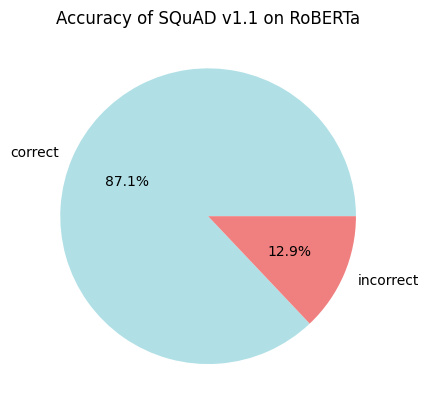

In [23]:
# general accuracy -> percentage of failure
labels = ['correct', 'incorrect']
values = [(num_total - num_failures), num_failures]

fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%', colors=['powderblue', 'lightcoral'])
plt.title("Accuracy of SQuAD v1.1 on RoBERTa")
plt.show()

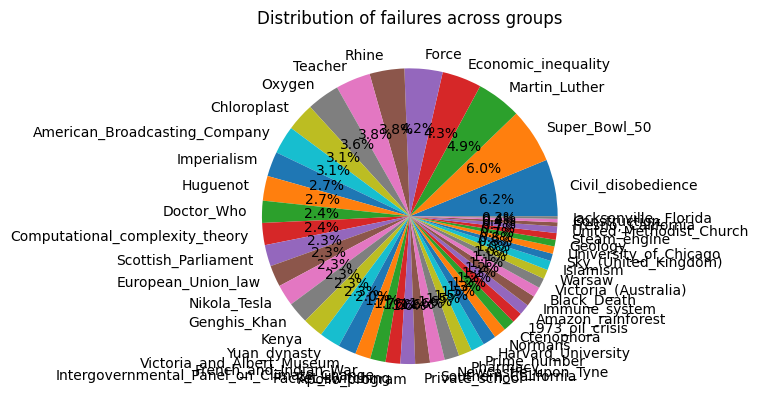

In [30]:
# distribution of failures across groups
group_failure_count = all_failures['title'].value_counts().to_dict()
labels = group_failure_count.keys()
values = group_failure_count.values()

fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("Distribution of failures across groups")
plt.show()

## Specific Failures Examples to Discuss

Context: As opposed to broadcasts of primetime series, CBS broadcast special episodes of its late night talk shows as its lead-out programs for Super Bowl 50, beginning with a special episode of The Late Show with Stephen Colbert following the game. Following a break for late local programming, CBS also aired a special episode of The Late Late Show with James Corden.

Question: What followed the late local programming after Super Bowl 50?
Correct Answer: The Late Late Show with James Corden

Response: NaN

Explanation:

---
Context: Börte had three more sons, Chagatai (1187—1241), Ögedei (1189—1241), and Tolui (1190–1232). Genghis Khan also had many other children with his other wives, but they were excluded from the succession. While the names of sons were documented, daughters were not. The names of at least six daughters are known, and while they played significant roles behind the scenes during his lifetime, no documents have survived that definitively provide the number or names of daughters born to the consorts of Genghis Khan.

Question: What year did two of Ghengis Khan and Börte's sons die?
Correct Answer: 1241

Response: 1190-12

Explanation:

---
Context: This projection was not included in the final summary for policymakers. The IPCC has since acknowledged that the date is incorrect, while reaffirming that the conclusion in the final summary was robust. They expressed regret for "the poor application of well-established IPCC procedures in this instance". The date of 2035 has been correctly quoted by the IPCC from the WWF report, which has misquoted its own source, an ICSI report "Variations of Snow and Ice in the past and at present on a Global and Regional Scale".

Question: What was the source of the mistake?
Correct Answers: the WWF report,the IPCC from the WWF report,the WWF report

Response: an ICSI report "Variations of Snow and Ice in the past and at present on a Global and Regional Scale".

Explanation

---

Context: Kenya ranks low on Transparency International's Corruption Perception Index (CPI), a metric which attempts to gauge the prevalence of public sector corruption in various countries. In 2012, the nation placed 139th out of 176 total countries in the CPI, with a score of 27/100. However, there are several rather significant developments with regards to curbing corruption from the Kenyan government, for instance, the establishment of a new and independent Ethics and Anti-Corruption Commission (EACC).

Question: Where does Kenya rang on the CPI scale?	Correct Answers: low,low,low

Response: 139th

Explanation
